<a href="https://colab.research.google.com/github/ISEA-Repositories/MLsessions/blob/main/FairnessCompare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

- Two populations, A & B.
- A is less likely to have the outcome than B.
- Simulated risk scores predicting the likelihood of the outcome.
- Risk scores are calibrated (is this fair?)
- False Positive Rates are different (is this fair?)


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Simulating data for populations A and B
np.random.seed(42)

N = 100000

# Simulating risk scores for populations A and B with different distributions
population_a_scores = np.random.normal(loc=0.45, scale=0.1, size=N)  # Lower mean for A
population_b_scores = np.random.normal(loc=0.55, scale=0.1, size=N)  # Higher mean for B

# Simulating binary outcomes (y_true) for calibration parity:
# We set the probability of the outcome being positive to match the risk score
y_true_a = (population_a_scores >= np.random.rand(N)).astype(int)
y_true_b = (population_b_scores >= np.random.rand(N)).astype(int)

# Convert to DataFrame for easier handling
data_a = pd.DataFrame({'population': 'A', 'risk_score': population_a_scores, 'y_true': y_true_a})
data_b = pd.DataFrame({'population': 'B', 'risk_score': population_b_scores, 'y_true': y_true_b})

# Combine data
data = pd.concat([data_a, data_b])

## Outcome Distribution and Risk Score Distribution

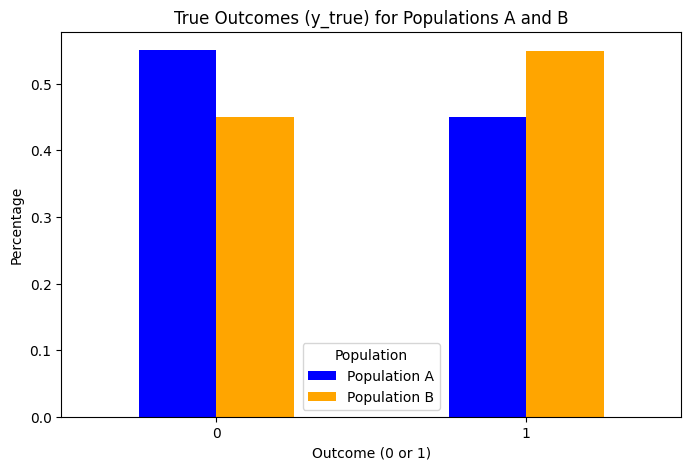

In [32]:
percentages = pd.concat([
    data_a['y_true'].value_counts(normalize=True),
    data_b['y_true'].value_counts(normalize=True)
], axis=1, keys=['Population A', 'Population B']).sort_index()

# Plot the percentages
percentages.plot(kind='bar', figsize=(8, 5), color=['blue', 'orange'])
plt.title('True Outcomes (y_true) for Populations A and B')
plt.xlabel('Outcome (0 or 1)')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Population')
plt.show()

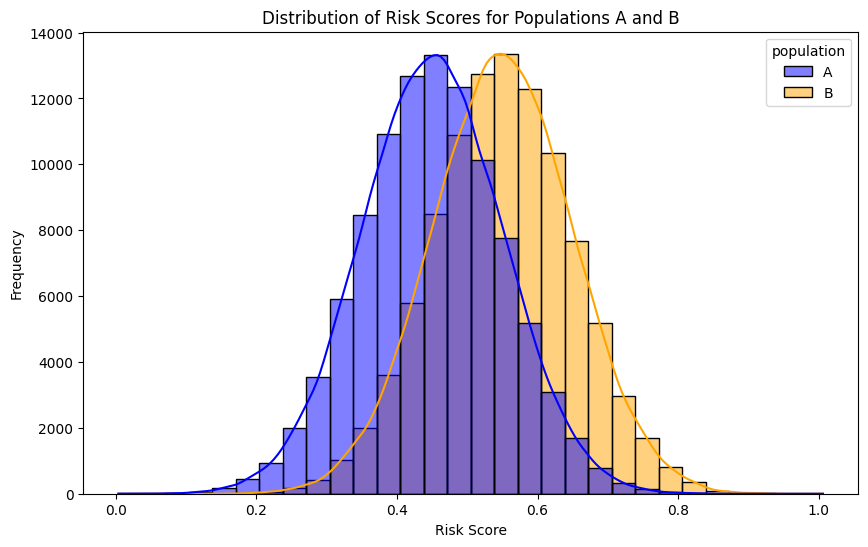

In [27]:
# Step 2: Plotting the distribution of risk scores for both populations
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='risk_score', hue='population', kde=True, bins=30, palette=['blue', 'orange'])
plt.title('Distribution of Risk Scores for Populations A and B')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.show()


## Calibration Parity
For a given risk score, the percentage of positive cases between two groups should be the same.

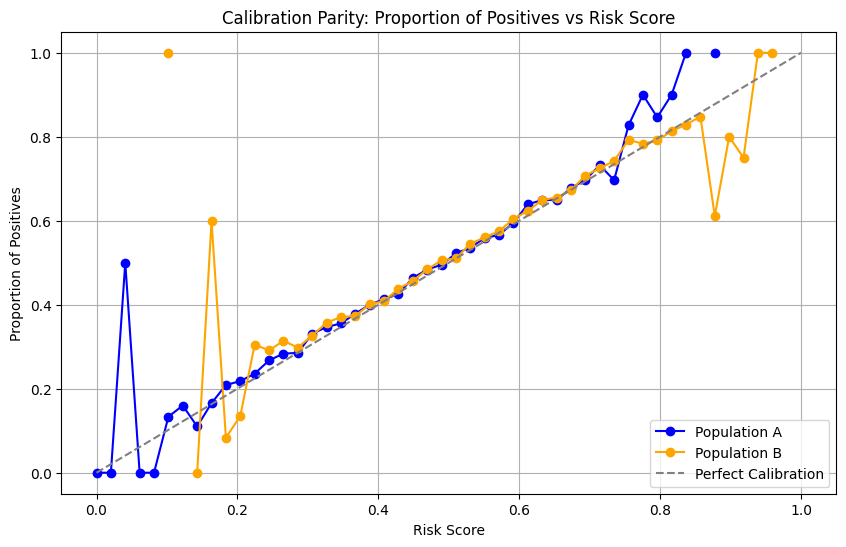

In [36]:
# Increased resolution by using smaller intervals
risk_score_bins = np.linspace(0, 1, 50)
calibration_a = []
calibration_b = []

for i in range(len(risk_score_bins)-1):
    lower, upper = risk_score_bins[i], risk_score_bins[i+1]

    # Proportion of positive outcomes for population A in each risk score bin
    calibration_a.append(np.mean(data_a[(data_a['risk_score'] >= lower) & (data_a['risk_score'] < upper)]['y_true']))

    # Proportion of positive outcomes for population B in each risk score bin
    calibration_b.append(np.mean(data_b[(data_b['risk_score'] >= lower) & (data_b['risk_score'] < upper)]['y_true']))

# Plotting Calibration Parity
plt.figure(figsize=(10, 6))
plt.plot(risk_score_bins[:-1], calibration_a, label='Population A', color='blue', marker='o')
plt.plot(risk_score_bins[:-1], calibration_b, label='Population B', color='orange', marker='o')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
plt.title('Calibration Parity: Proportion of Positives vs Risk Score')
plt.xlabel('Risk Score')
plt.ylabel('Proportion of Positives')
plt.legend()
plt.grid(True)
plt.show()


# False Positive Rate
Across groups, the percentage of False-positives should be the same. This is threshold dependent.

In [39]:
def false_positive_rate(y_true, y_pred):
    # False Positive Rate = FP / (FP + TN)
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False positives
    tn = np.sum((y_true == 0) & (y_pred == 0))  # True negatives
    return fp / (fp + tn) if (fp + tn) > 0 else 0

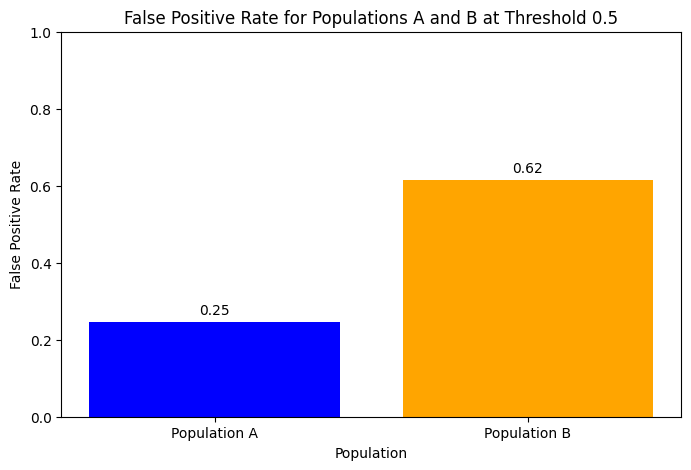

In [40]:
# Calculate FPR for both populations at threshold 0.5
threshold = 0.5

# For Population A
y_pred_a = (data_a['risk_score'] >= threshold).astype(int)
fpr_a = false_positive_rate(data_a['y_true'], y_pred_a)

# For Population B
y_pred_b = (data_b['risk_score'] >= threshold).astype(int)
fpr_b = false_positive_rate(data_b['y_true'], y_pred_b)

# Step 3: Create a bar chart for FPR
labels = ['Population A', 'Population B']
fpr_values = [fpr_a, fpr_b]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, fpr_values, color=['blue', 'orange'])
plt.xlabel('Population')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate for Populations A and B at Threshold 0.5')
plt.ylim(0, 1)

# Display the value of FPR on top of the bars
for i, value in enumerate(fpr_values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center')

plt.show()

### What if we vary the threshold?

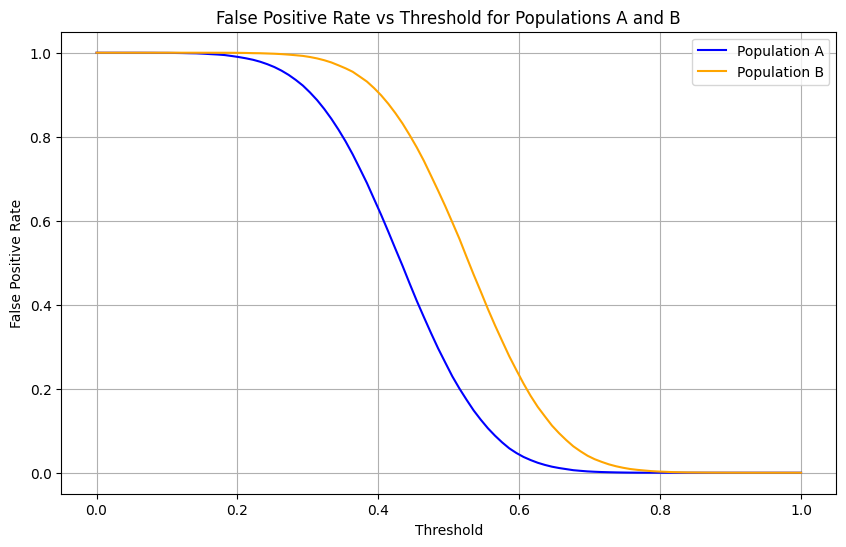

In [41]:


# Define the thresholds and calculate FPR at each threshold
thresholds = np.linspace(0, 1, 100)
fpr_a = []
fpr_b = []

for threshold in thresholds:
    # Classification based on threshold for population A
    y_pred_a = (data_a['risk_score'] >= threshold).astype(int)
    fpr_a.append(false_positive_rate(data_a['y_true'], y_pred_a))

    # Classification based on threshold for population B
    y_pred_b = (data_b['risk_score'] >= threshold).astype(int)
    fpr_b.append(false_positive_rate(data_b['y_true'], y_pred_b))

# Plotting False Positive Rate vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fpr_a, label='Population A', color='blue')
plt.plot(thresholds, fpr_b, label='Population B', color='orange')
plt.title('False Positive Rate vs Threshold for Populations A and B')
plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# AUC
Aggregate measure of a model's ability to distinguish between the positive and negative classes across different decision thresholds.

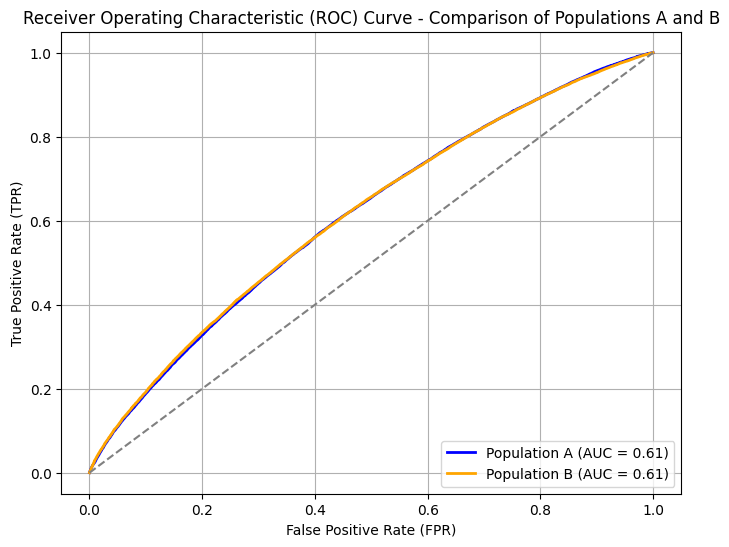

In [43]:
from sklearn.metrics import roc_curve, auc
# Extract the true labels and predicted probabilities (risk scores) for each population
y_true_a = data_a['y_true']
y_pred_prob_a = data_a['risk_score']

y_true_b = data_b['y_true']
y_pred_prob_b = data_b['risk_score']

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds for each population
fpr_a, tpr_a, _ = roc_curve(y_true_a, y_pred_prob_a)
fpr_b, tpr_b, _ = roc_curve(y_true_b, y_pred_prob_b)

# Calculate AUC (Area Under the Curve) for each population
roc_auc_a = auc(fpr_a, tpr_a)
roc_auc_b = auc(fpr_b, tpr_b)

# Plot ROC curves for both populations
plt.figure(figsize=(8, 6))
plt.plot(fpr_a, tpr_a, color='blue', lw=2, label=f'Population A (AUC = {roc_auc_a:.2f})')
plt.plot(fpr_b, tpr_b, color='orange', lw=2, label=f'Population B (AUC = {roc_auc_b:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.title('Receiver Operating Characteristic (ROC) Curve - Comparison of Populations A and B')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()